In [1]:
import numpy as np
from csc.mmp import *
from csc.utils import *
from csc.atoms import *
from csc.workbench import *
from csc.dictionary import *
from itertools import product
import matplotlib.pyplot as plt

# Atom parameters
bmin = 0.005
bmax = 0.06
b_step = 0.005
b_values = np.arange(bmin, bmax, b_step)

ymin = 0.010
ymax = 0.036
y_step = 0.002
y_values = np.arange(ymin, ymax, y_step)

s_values = [1]

dictionary = ZSDictionary.from_values(b_values, y_values, s_values)
print('The dictionary has {} different atoms'.format(len(dictionary)))

The dictionary has 143 different atoms


### Workbench initialization with a database path

In [2]:
batchSize = 200
path_to_signals_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-signals-{batchSize}.json'
path_to_mmpdf_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mmpdf-{batchSize}.json'
path_to_mp_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mp-{batchSize}.json'

workbench = CSCWorkbench(path_to_signals_db)
workbench.load_data()
workbench.set_dictionary(dictionary)

In [3]:
with open(path_to_signals_db, 'r') as f:
            output_data = json.load(f)
            signals_results = output_data['signals']

id0 = next(x['id'] for x in signals_results if x['sparsity'] == 6 and x['snr'] == 10)
signal_id = id0+4
signal_dict = workbench.signalDictFromId(signal_id)

In [4]:
noisy_signal = signal_dict['signal']
true_signal = np.zeros_like(noisy_signal)
for atom in signal_dict['atoms']:
    zs_atom = ZSAtom.from_dict(atom)
    zs_atom.padBothSides(dictionary.getAtomsLength())
    zs_atom_signal = zs_atom.getAtomInSignal(signal_length=len(noisy_signal), offset=atom['x'])
    true_signal += zs_atom_signal

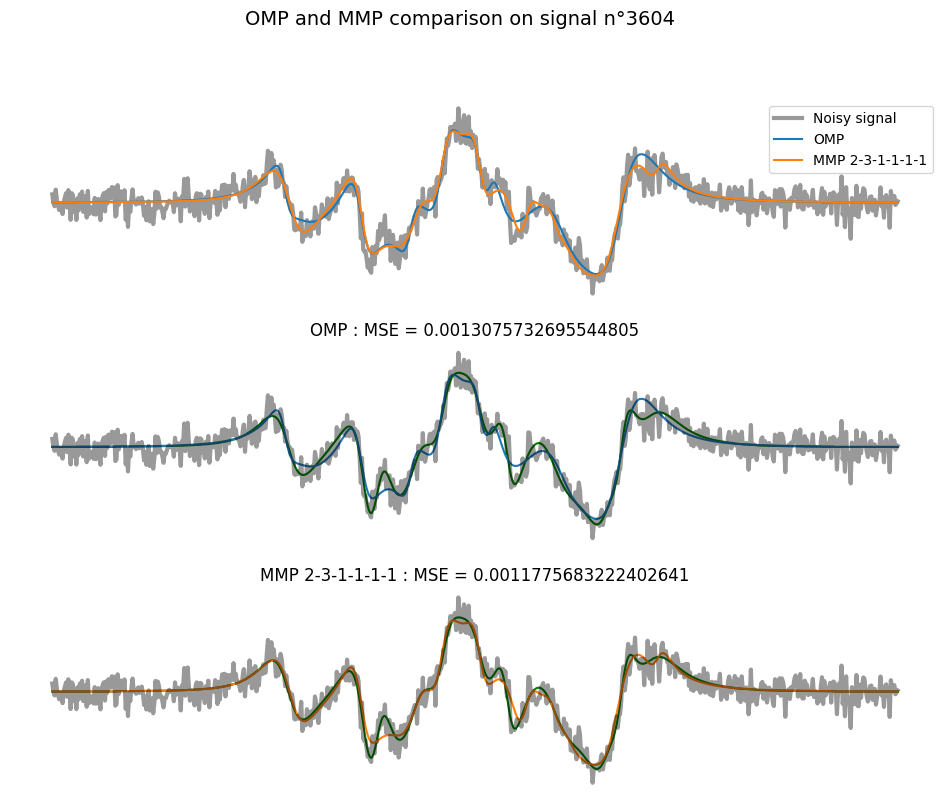

In [5]:
workbench.plotMMPComparison(path_to_mmpdf_db, id=signal_id)

### Test activation vector from DB dict

In [6]:
with open(path_to_mmpdf_db, 'r') as f:
    output_data = json.load(f)
    mmpdf_results = output_data['mmp']


mmp_tree_dict = next(mmpdf_dict['mmp-tree'] for mmpdf_dict in mmpdf_results if mmpdf_dict['id'] == signal_id)
signal_dict = next(x for x in signals_results if x['id'] == signal_id)
tree_sparsity, tree_connections = MMPTree.getTreeParamsFromMMPTreeDict(mmp_tree_dict=mmp_tree_dict)

# Get the branch with the lowest MSE according to the DB
mmp_path_str = '2-3-1-1-1-1'
mmp_branch_dict = mmp_tree_dict[mmp_path_str]
path_list = list(map(int, mmp_path_str.split('-')))

print(f'MMP-DF {mmp_path_str} : MSE = {mmp_branch_dict["mse"]} : ')
for node_number, atom in zip(path_list, mmp_tree_dict[mmp_path_str]['atoms']):
    print(f'    {node_number} - {atom}')

MMP-DF 2-3-1-1-1-1 : MSE = 0.0011775683222402641 : 
    2 - {'x': 205, 'b': 0.045, 'y': 0.034, 's': 7.209068871352413e-05}
    3 - {'x': 58, 'b': 0.034999999999999996, 'y': 0.016, 's': 2.4700769240040715e-05}
    1 - {'x': 15, 'b': 0.055, 'y': 0.024, 's': 4.556146388937286e-05}
    1 - {'x': 146, 'b': 0.02, 'y': 0.014, 's': 1.9224997624588253e-05}
    1 - {'x': 224, 'b': 0.02, 'y': 0.022, 's': 3.693602068568517e-05}
    1 - {'x': 236, 'b': 0.045, 'y': 0.012, 's': 1.648862170323877e-05}


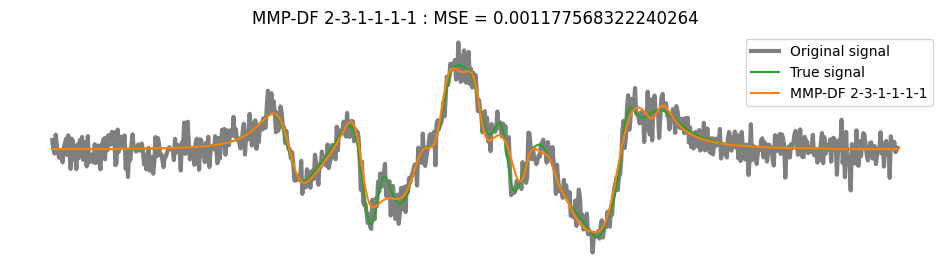

In [7]:
mmp_atoms = mmp_branch_dict['atoms']
approx, _ = dictionary.getSignalProjectionFromAtoms(signal=noisy_signal, atoms_dicts=mmp_atoms)
mse = np.mean((approx - noisy_signal)**2)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(signal_dict['signal'], label='Original signal', color='k', lw=3, alpha=0.5)
ax.plot(true_signal, label='True signal', color='C2')
ax.plot(approx, label='MMP-DF 2-3-1-1-1-1', color='C1')
ax.legend(loc='best')
plt.title(f'MMP-DF 2-3-1-1-1-1 : MSE = {mse}')
plt.axis('off')
plt.show()

OMP atoms :
    {'x': 195, 'b': 0.055, 'y': 0.03, 's': 6.2248555025221e-05}
    {'x': 21, 'b': 0.055, 'y': 0.034, 's': 7.393805589498585e-05}
    {'x': 58, 'b': 0.034999999999999996, 'y': 0.016, 's': 2.4700769240040715e-05}
    {'x': 222, 'b': 0.025, 'y': 0.032, 's': 6.596752580999086e-05}
    {'x': 11, 'b': 0.055, 'y': 0.012, 's': 1.653959710339202e-05}
    {'x': 131, 'b': 0.005, 'y': 0.01, 's': 1.3516616682807639e-05}
MMP-DF 2-3-1-1-1-1 atoms :
    {'x': 205, 'b': 0.045, 'y': 0.034, 's': 7.209068871352413e-05}
    {'x': 58, 'b': 0.034999999999999996, 'y': 0.016, 's': 2.4700769240040715e-05}
    {'x': 15, 'b': 0.055, 'y': 0.024, 's': 4.556146388937286e-05}
    {'x': 146, 'b': 0.02, 'y': 0.014, 's': 1.9224997624588253e-05}
    {'x': 224, 'b': 0.02, 'y': 0.022, 's': 3.693602068568517e-05}
    {'x': 236, 'b': 0.045, 'y': 0.012, 's': 1.648862170323877e-05}
OMP MSE = 0.0013075732695544805
MMP 2-3-1-1-1-1 MSE = 0.001177568322240264


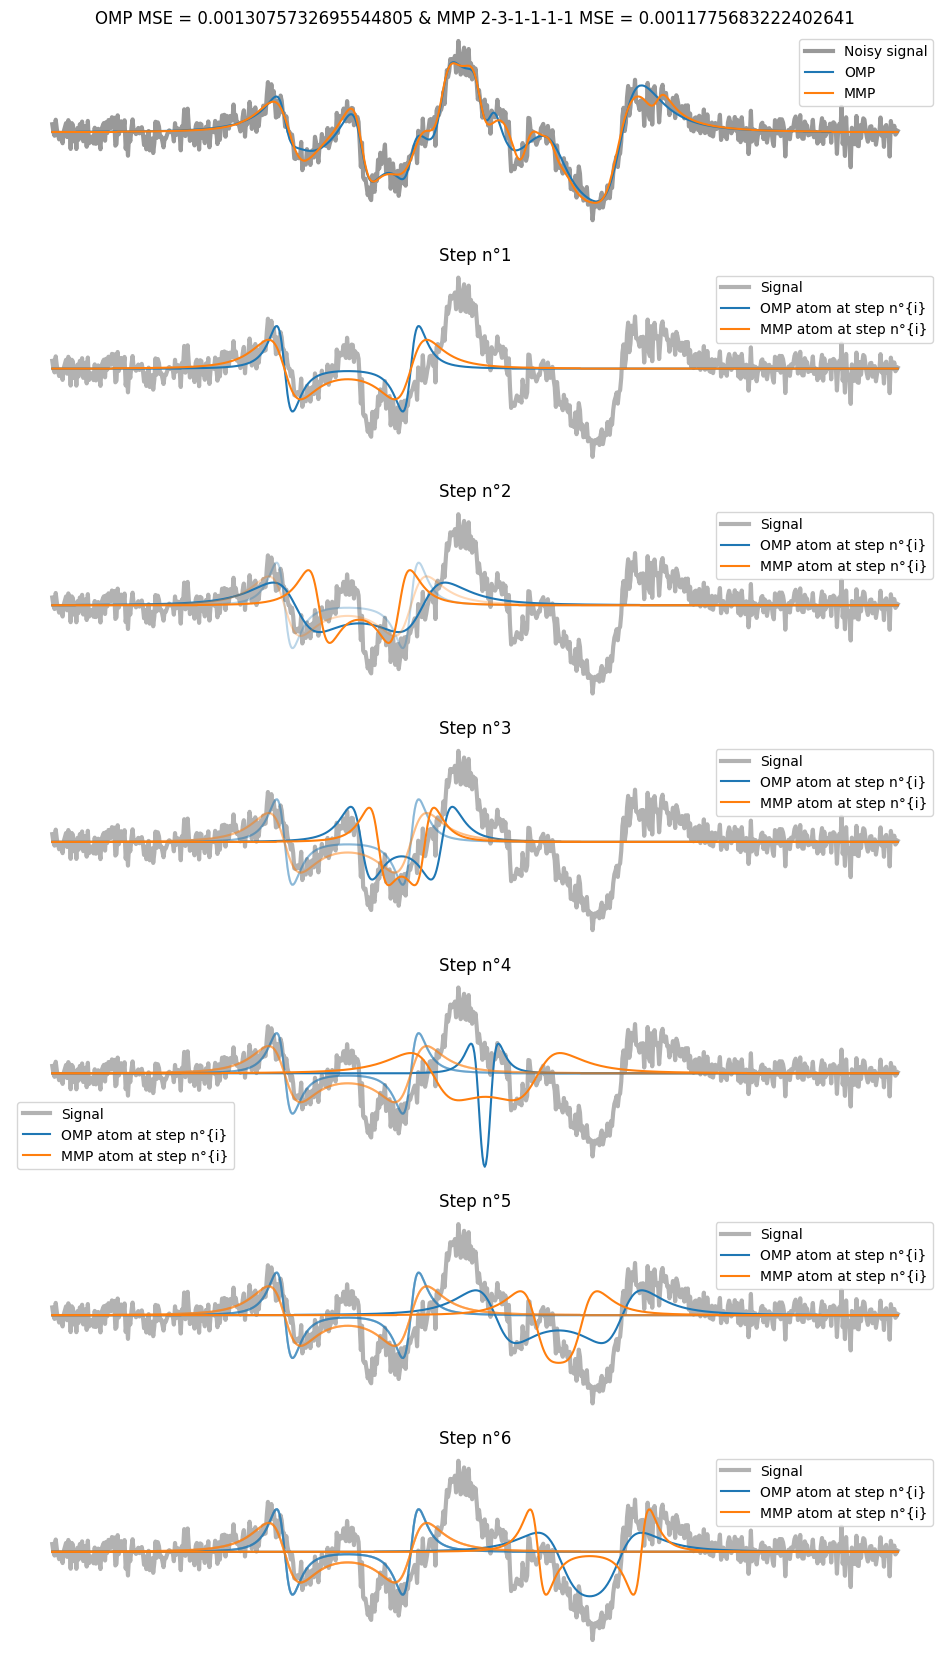

In [8]:
workbench.plotMMPDecomposition(path_to_mmpdf_db, id=signal_id, verbose=True)

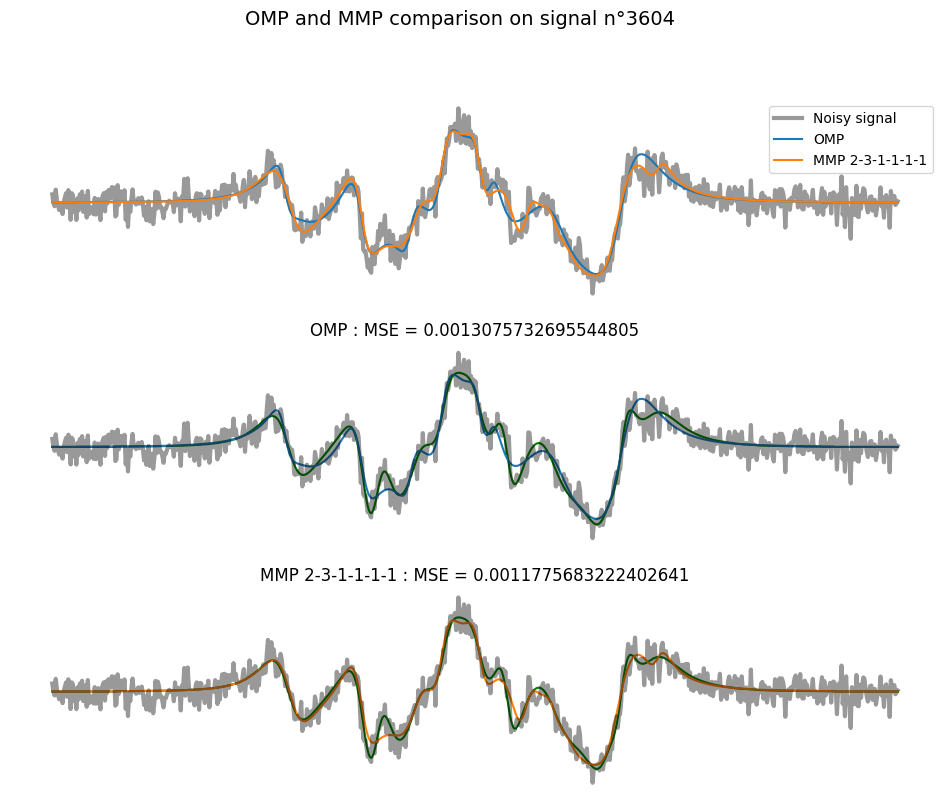

In [9]:
workbench.plotMMPComparison(path_to_mmpdf_db, id=signal_id)